In [1]:
import os, sys
sys.path.append("..")

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import gc

from src import distributions
import torch.nn.functional as F
from IPython.display import clear_output

from src.tools import unfreeze, freeze
from src import distributions

from src.plotters import plot_1D

from tqdm.notebook import tqdm as tqdm

%load_ext autoreload
%autoreload 2

In [2]:
DEVICE_IDS = [2]

T_ITERS = 10
f_LR, T_LR = 1e-4, 1e-4

ZD = 1
Z_STD = 0.1

BATCH_SIZE = 64
Z_SIZE = 4

COST = 'energy' # 'weak_mse'
GAMMA = 1.

PLOT_INTERVAL = 200
MAX_STEPS = 5001
SEED = 0x000000

In [3]:
DIM = 1

assert torch.cuda.is_available()
torch.cuda.set_device(DEVICE_IDS[0])
torch.manual_seed(SEED)
np.random.seed(SEED)

In [4]:
X_sampler = distributions.StandardNormalSampler(dim=1)
# X_sampler = distributions.StandardNormalScaler(distributions.MixNGaussiansSampler(dim=1, n=3)) # <-- 3 Gaussians

Y_sampler = distributions.StandardNormalScaler(distributions.MixNGaussiansSampler(dim=1, n=2)) # <-- 2 Gaussians
# Y_sampler = distributions.StandardNormalScaler(distributions.StandardNormalSampler(dim=1))  # <-- Normal
# Y_sampler = distributions.StandardNormalScaler(distributions.CubeUniformSampler(dim=1)) # <-- Uniform

In [5]:
def weights_init_mlp(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

H = 100

T = nn.Sequential(
    nn.Linear(DIM+ZD, H),
    nn.ReLU(True), 
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, DIM)
).cuda()

f = nn.Sequential(
    nn.Linear(DIM, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, 1)
).cuda()

T.apply(weights_init_mlp); f.apply(weights_init_mlp)

if len(DEVICE_IDS) > 1:
    T = nn.DataParallel(T, device_ids=DEVICE_IDS)
    f = nn.DataParallel(f, device_ids=DEVICE_IDS)

print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

T params: 20601
D params: 20501


In [6]:
T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=f_LR, weight_decay=1e-10)

Step 5000
Plotting


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'xlim', 'ylim'
  cset = contour_func(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'xlim', 'ylim'
  cset = contour_func(
/opt/anaco

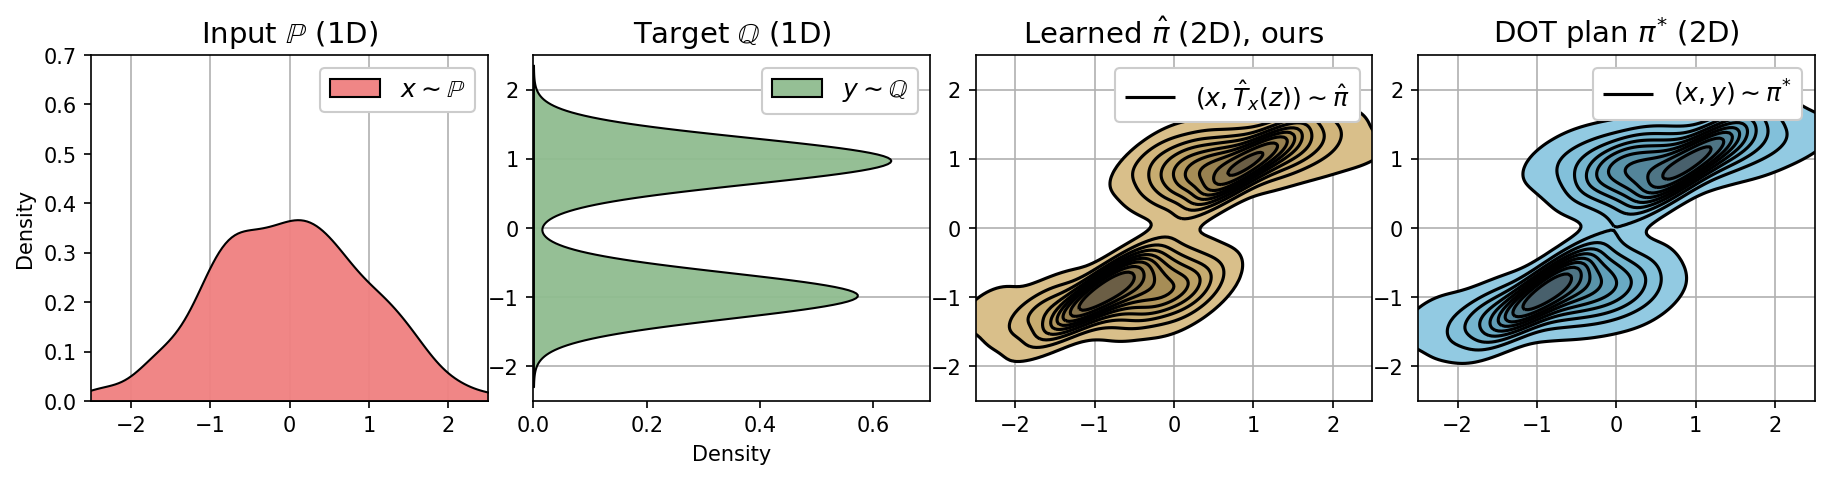

In [7]:
for step in tqdm(range(MAX_STEPS)):
    # T optimization
    unfreeze(T); freeze(f)
    for t_iter in range(T_ITERS):
        T_opt.zero_grad()
        X = X_sampler.sample(BATCH_SIZE).reshape(-1, 1, DIM).repeat(1, Z_SIZE, 1)
        with torch.no_grad():
            Z = torch.randn(BATCH_SIZE, Z_SIZE, ZD, device='cuda') * Z_STD
            XZ = torch.cat([X, Z], dim=2)
        T_XZ = T(
            XZ.flatten(start_dim=0, end_dim=1)
        ).permute(1, 0).reshape(DIM, -1, Z_SIZE).permute(1, 2, 0)
        
        if COST == 'weak_mse':
            T_loss = F.mse_loss(X, T_XZ).mean() - GAMMA * T_XZ.var(dim=1).mean() -\
            f(T_XZ.flatten(start_dim=0, end_dim=1)).mean() 
        elif COST == 'energy':
            T_loss = (X-T_XZ).norm(dim=2).mean() - f(T_XZ.flatten(start_dim=0, end_dim=1)).mean() -\
            GAMMA * .5 * torch.cdist(T_XZ, T_XZ).mean() * Z_SIZE / (Z_SIZE -1)
        else:
            raise Exception('Unknown cost')
        T_loss.backward(); T_opt.step()
    
    del T_loss, T_XZ, X, Z
    gc.collect(); torch.cuda.empty_cache()

    # f optimization
    
    freeze(T); unfreeze(f)

    X = X_sampler.sample(BATCH_SIZE)
    with torch.no_grad():
        Z = torch.randn(BATCH_SIZE, ZD, device='cuda') * Z_STD
        XZ = torch.cat([X, Z], dim=1)
        T_XZ = T(XZ)
    Y = Y_sampler.sample(BATCH_SIZE)

    f_opt.zero_grad()
    f_loss = f(T_XZ).mean() - f(Y).mean()
    f_loss.backward(); f_opt.step()

    del f_loss, Y, X, T_XZ, Z, XZ
    gc.collect(); torch.cuda.empty_cache()

    if step % PLOT_INTERVAL == 0:
        clear_output(wait=True)
        print("Step", step)
        print("Plotting")

        flag = True if ((step == MAX_STEPS-1) and (COST == 'energy')) else False
        fig, axes = plot_1D(X_sampler, Y_sampler, T, ZD, Z_STD, num_samples=1024, plot_discrete=flag, gamma=GAMMA)
        plt.show()

    gc.collect()
    torch.cuda.empty_cache()